In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import sys, os
from time import time
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV
sns.set_style('darkgrid')
idx = pd.IndexSlice
YEAR = 252

with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))
data = data.drop([c for c in data.columns if 'year' in c or 'lag' in c], axis=1)
data = data[data.dollar_vol_rank<100]

y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

In [4]:
train_period_length = 63
test_period_length = 10
lookahead =1
n_splits = int(3 * YEAR/test_period_length)

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)
target = f'target_{lookahead}d'

y.loc[:, 'label'] = (y[target] > 0).astype(int)
y.label.value_counts()

Cs = np.logspace(-5, 5, 11)
cols = ['C', 'date', 'auc', 'ic', 'pval']

In [5]:
%%time
log_coeffs, log_scores, log_predictions = {}, [], []
for C in Cs:
    print(C) #正则强度，值越小正则越强
    model = LogisticRegression(C=C, fit_intercept=True, random_state=42, n_jobs=-1)
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    ics = aucs = 0
    
    start = time()
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y.label.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.label.iloc[test_idx]
        if len(y_test) < 10 or len(np.unique(y_test)) < 2: #后者表示只有1个label无法计算auc
            continue
        pipe.fit(X=X_train, y=y_train)
        ## 知识点，pipe操作
        y_score = pipe.predict_proba(X_test)[:, 1]
       
        auc = roc_auc_score(y_score=y_score, y_true=y_test)
        actuals = y[target].iloc[test_idx]
        ic, pval = spearmanr(y_score, actuals)

        log_predictions.append(y_test.to_frame('labels').assign(predicted=y_score, C=C, actuals=actuals))
        date = y_test.index.get_level_values('date').min()
        log_scores.append([C, date, auc, ic * 100, pval])
        coeffs.append(pipe.named_steps['model'].coef_)
        ics += ic
        aucs += auc
        if i % 10 == 0:
            print(f'\t{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {aucs/i:>7.2%}')

    log_coeffs[C] = np.mean(coeffs, axis=0).squeeze()

1e-05
	  4.1 | 010 |  -0.31% |  50.42%
	 10.5 | 020 |   1.89% |  51.83%
	 20.7 | 030 |   2.84% |  52.01%
	 31.0 | 040 |   3.29% |  51.98%
	 41.3 | 050 |   3.97% |  52.44%
	 51.6 | 060 |   3.96% |  52.27%
	 61.9 | 070 |   4.73% |  52.59%
0.0001
	 10.4 | 010 |  -0.06% |  50.62%
	 20.6 | 020 |   2.23% |  52.01%
	 30.9 | 030 |   3.20% |  52.26%
	 41.2 | 040 |   3.34% |  52.08%
	 51.4 | 050 |   4.02% |  52.53%
	 61.7 | 060 |   4.02% |  52.33%
	 72.0 | 070 |   4.83% |  52.67%
0.001
	 10.3 | 010 |   0.42% |  50.96%
	 20.6 | 020 |   2.53% |  52.14%
	 30.8 | 030 |   3.58% |  52.48%
	 41.1 | 040 |   3.17% |  52.07%
	 51.4 | 050 |   3.83% |  52.49%
	 61.7 | 060 |   4.03% |  52.33%
	 72.0 | 070 |   4.88% |  52.70%
0.01
	 10.4 | 010 |   0.68% |  51.13%
	 20.7 | 020 |   2.39% |  51.97%
	 31.0 | 030 |   3.64% |  52.41%
	 41.4 | 040 |   3.12% |  51.94%
	 51.7 | 050 |   3.92% |  52.46%
	 62.1 | 060 |   4.16% |  52.30%
	 72.4 | 070 |   4.91% |  52.64%
0.1
	 10.4 | 010 |   0.65% |  51.11%
	 20.8 | 020 | 

In [6]:
log_scores = pd.DataFrame(log_scores, columns=cols)
log_coeffs = pd.DataFrame(log_coeffs, index=X.columns).T
log_predictions = pd.concat(log_predictions)
log_scores.to_hdf('data.h5', 'logistic/scores')
log_coeffs.to_hdf('data.h5', 'logistic/coeffs')
log_predictions.to_hdf('data.h5', 'logistic/predictions')

log_scores = pd.read_hdf('data.h5', 'logistic/scores')
log_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   C       825 non-null    float64       
 1   date    825 non-null    datetime64[ns]
 2   auc     825 non-null    float64       
 3   ic      825 non-null    float64       
 4   pval    825 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 38.7 KB


In [7]:
log_scores.groupby('C').auc.describe()

,count,mean,std,min,25%,50%,75%,max
C,,,,,,,,
0.00001,75.0,0.524316,0.036131,0.432491,0.499719,0.519363,0.546030,0.625816
0.00010,75.0,0.525045,0.035658,0.442738,0.501438,0.520094,0.546003,0.635535
0.00100,75.0,0.525448,0.036371,0.438676,0.500371,0.520211,0.545218,0.641011
0.01000,75.0,0.525076,0.036905,0.435870,0.500481,0.522237,0.550842,0.641632
0.10000,75.0,0.523552,0.036496,0.427256,0.499836,0.523206,0.549261,0.621749
1.00000,75.0,0.523159,0.036445,0.424981,0.498530,0.521782,0.549033,0.616444
10.00000,75.0,0.523109,0.036423,0.424850,0.498587,0.521569,0.548962,0.615767
100.00000,75.0,0.523104,0.036422,0.424826,0.498593,0.521573,0.548949,0.615716
1000.00000,75.0,0.523102,0.036423,0.424812,0.498597,0.521582,0.548951,0.615728


In [8]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)    
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9, s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

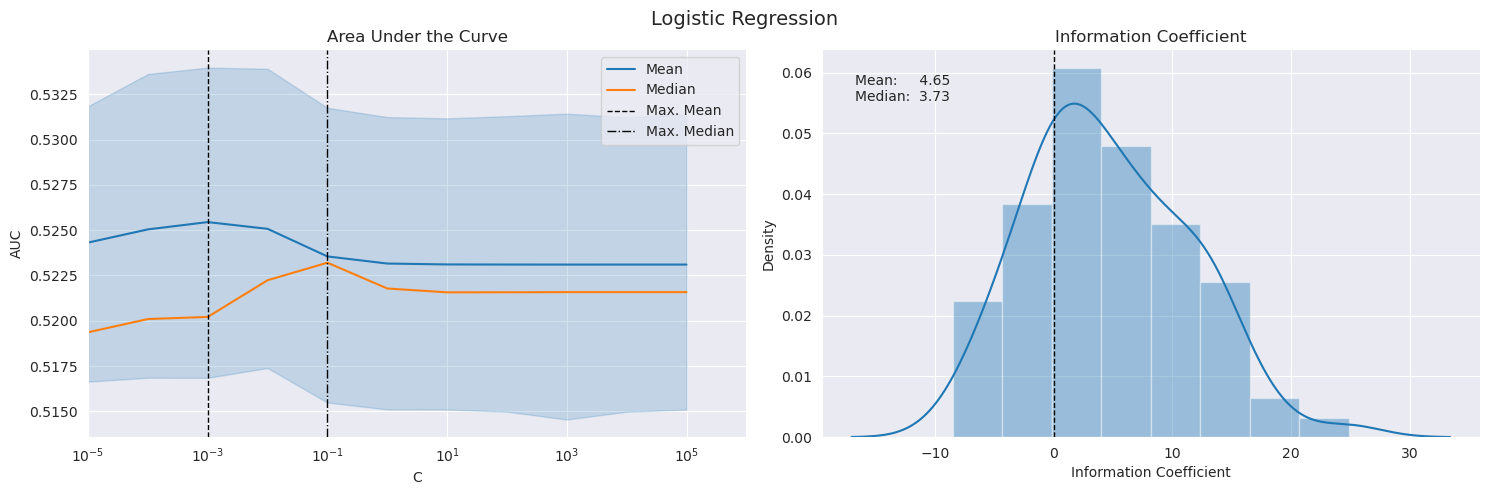

In [9]:
fig, axes= plt.subplots(ncols=2, figsize=(15, 5))

sns.lineplot(x='C', y='auc', data=log_scores, estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = log_scores.groupby('C').auc.agg(['mean', 'median'])
best_auc = by_alpha['mean'].idxmax()
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median', xlim=(10e-6, 10e5))
axes[0].axvline(best_auc, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_ylabel('AUC')
axes[0].set_xscale('log')
axes[0].set_title('Area Under the Curve')

plot_ic_distribution(log_scores[log_scores.C==best_auc], ax=axes[1])
axes[1].set_title('Information Coefficient')

fig.suptitle('Logistic Regression', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);